# Brightnes profiles for the deconvolved and initial polarimetric images

- radial profiles and check for the order of PSF smearing correction and deconvolution
- test for the possibility of calculation scattered light persentage from total intensity image

## Functions

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

def plot_with_same_color(data, keys, labels,title,star,lim1,arcsinh,cameras):
    #min and max values setted manually here to 0 and 1
    num_keys = len(keys)
    ncols = int(np.ceil(np.sqrt(num_keys)))  # Adjust the number of rows as needed
    nrows = int(np.ceil(num_keys / ncols))
    fig = plt.figure(figsize=(12, 8))
    data_arcshin={}
    for idx, key in enumerate(keys):
        if arcsinh==True:
            data_arcshin[key] =np.arcsinh(data[key]) 
        else:
            data_arcshin[key] = data[key]
    # Using GridSpec to create a more flexible subplot layout
       
    gs = GridSpec(nrows, ncols, figure=fig, wspace=0.1, hspace=0.25)
    # Calculate vmin and vmax for all images
    n = data_arcshin[key].shape[0]
    vmin = np.min([np.min(data_arcshin[key][int(n/2-lim1):int(n/2+lim1), int(n/2-lim1):int(n/2+lim1)]) for key in keys])
    vmax = np.max([np.max(data_arcshin[key][int(n/2-lim1):int(n/2+lim1), int(n/2-lim1):int(n/2+lim1)]) for key in keys])

    for idx, key in enumerate(keys):
        if cameras[idx]=='IRDIS':
            ps=12.27
            lim=lim1*1.0
        else:
            ps=3.6
            lim=lim1*12.27/3.6
            
        ax = fig.add_subplot(gs[idx])
        n = data_arcshin[key].shape[0]
        d = (n-1) * ps / 2
        im = ax.imshow(data_arcshin[key], extent=(-d, d, -d, d), vmin=vmin, vmax=vmax,origin='lower')
        #plotting contour
        if arcsinh:
            levels=[np.arcsinh(np.max(data[key])/64),np.arcsinh(np.max(data[key])/32),np.arcsinh(np.max(data[key])/16),np.arcsinh(np.max(data[key])/8),np.arcsinh(np.max(data[key])/4),np.arcsinh(np.max(data[key])/2)]
        else:
            levels=[np.max(data[key])/64,np.max(data[key])/32,np.max(data[key])/16,np.max(data[key])/8,np.max(data[key])/4,np.max(data[key])/2]
        CS=ax.contour(data_arcshin[key], levels=levels,colors=['black', 'brown', 'red','purple','pink','white'], extent=(-d, d, -d, d))
        ax.clabel(CS, inline=True, fontsize=10)
        
        ax.set_title(labels[key])
        ax.set_xlabel('mas')
        ax.set_ylabel('mas')
        ax.set_xlim(-lim * ps, lim * ps)
        ax.set_ylim(-lim * ps, lim * ps)
        ax.label_outer()

    # Create a common colorbar for all images
    cax = fig.add_axes([0.95, 0.22, 0.02, 0.55])  # Adjust the position of colorbar as needed
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(star+' '+title, fontsize=16)#,y=0.85)

    #specific_folder=figfolder+'models/'
    #try:
    # Create target Directory
    #   os.mkdir(specific_folder)
    #except FileExistsError:
    #    print("Directory " , specific_folder,  " already exists")
   
    #plt.savefig(specific_folder +star+'_'+title+".jpeg",bbox_inches='tight', pad_inches=0.1)
    #plt.show()
    


def LoadImage(dirdat,filename):
    dir =dirdat
    psfile =  filename
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            fit = hdulPSF[0].data

            
    return fit

def LoadImage_dec (dir,annulus):

    files = os.listdir(dir)
    for fil in files:
        if fnmatch.fnmatch(fil, '*'+annulus+'_decon.fits'):
            hdu = fits.open(dir+fil)
            image = hdu[0].data
            ps =3.6
            n=image.shape[0]
            d=(n-1)/2
            x = np.linspace(-d, d, n)
            y = np.linspace(-d, d, n)
            x2, y2 = np.meshgrid(x, y)
            R = np.sqrt(x2**2+y2**2)
    return image, R, x, y, d,x2,y2


def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")   
        




def load_I(dirdat,camera):
    dir = dirdat
    qfile = '*sci'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            q = hdulq[0].data[1]
            iu = hdulq[0].data[2]
            u = hdulq[0].data[3]
            n=q.shape[0]
            i=(iq+iu)/2
            
    return iq,iu,i


   
def Loadimagespsf(star,dirdat,band):
    dir = dirdat
    qfile = '*_'+band+'_I_meancombined.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]

                print(n)
    return image, n


def plotImage(image, lim):
    n = image.shape[0]
    fig, ax = plt.subplots(figsize=(8,6))
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for zimpol
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas', fontsize=20)
    plt.ylabel('mas', fontsize=20)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)     
    plt.colorbar()
    plt.tight_layout
    return fig, ax
    
def Loadimages_notdeconv(star,fittype,dirdat,band, extension):
    dir = dirdat
    qfile = star+'_'+band+'_'+fittype+extension+'.fits'
    print(qfile)
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                print(image[1,4])
                n = image.shape[0]
                
    return image, n

def Loadimages(dirdat,band, extension):
    dir = dirdat
    qfile = band+extension+'.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]
                
    return image, n



## Set up

In [10]:
stars=['AR_Pup_dc_notnorm']
ref_of_sci={'AR_Pup_dc_notnorm':'HD75885','UMon':'HD71253','UMon_Katya':'HD71253','V709_Car':'HD94680','HR4049_20190108':'HD96314','HR4049_20190107':'HD96314','HR4226':'HD98025',"HR4049_combined":'HD96314'} #the corresponding scientific targets, SPHERE proposals
disk_incl_pa={'AR_Pup_dc_notnorm':[75,45],'UMon':[25,144],'UMon_Katya':[25,144],'V709_Car':[34,13],'HR4049_20190108':[49,63],'HR4049_20190107':[49,63],"HR4049_combined":[49,63],'HR4226':[0,1]} #Kluska_2019 for HR4049 V709Car, UMon from Andrych2023, AR Pup...have to check, this are from my table, HR4226 - just circle

star = stars[0]

incl_pa=disk_incl_pa[star]
fittypes=['1', '2']

band=['V','I']
ps=3.6
dirdat0 = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'


normlim=120


## Comparison of deconvolved data just after correction of telescope polarisation, without substraction of unresolved



V
reference                      max_DoLP[%] max_Q_phi  max_PI     sumQ_phi/I[%] sumPI/I[%] sumIe6     
deconvolved                    73.020     806.709     452.099    3.459      4.797       0.27709   
deconvolved+smearing           1147.739   11288.416   19018.908  10.768     23.029      
I
reference                      max_DoLP[%] max_Q_phi  max_PI     sumQ_phi/I[%] sumPI/I[%] sumIe6     
deconvolved                    59.799     842.150     955.537    3.725      4.379       0.26611   
deconvolved+smearing           1240.922   38823.350   40724.215  16.310     30.708      


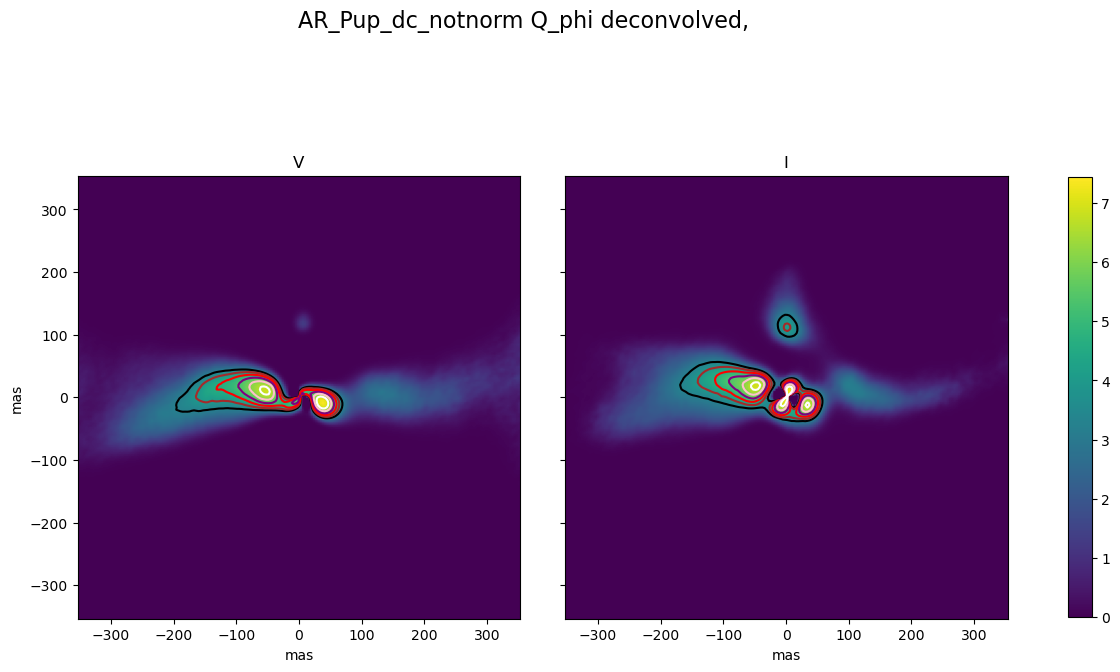

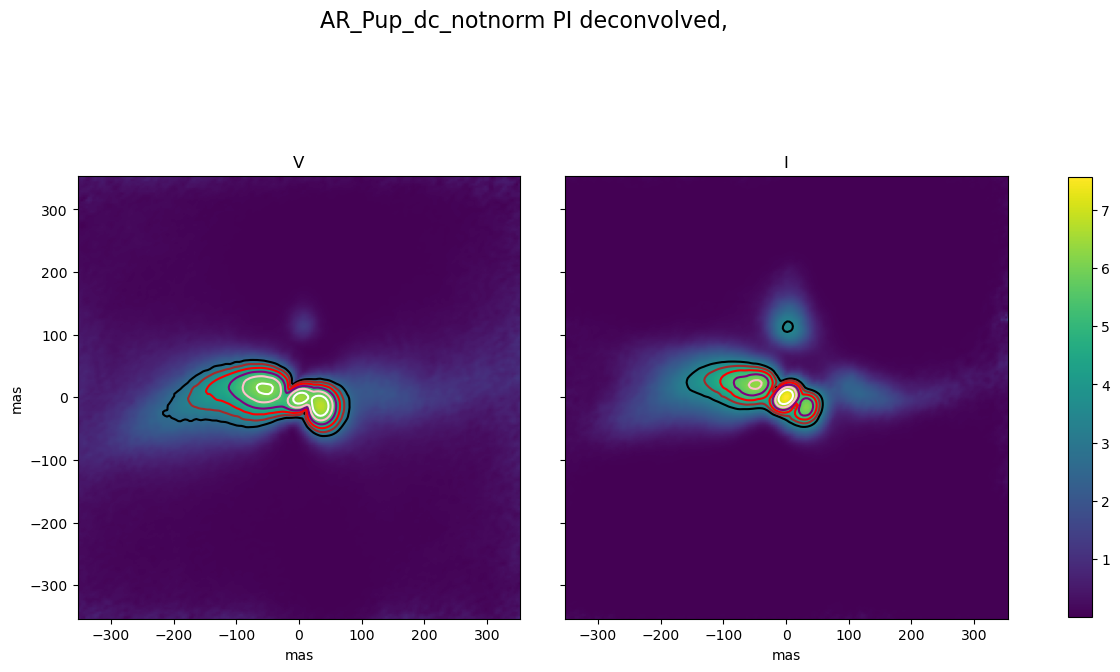

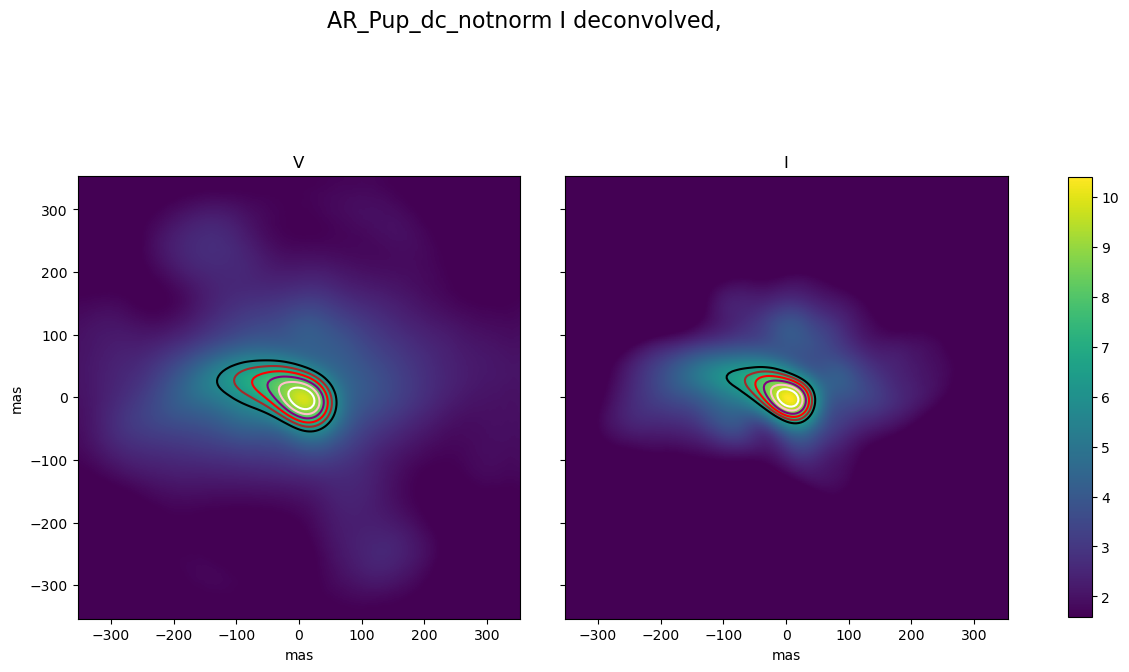

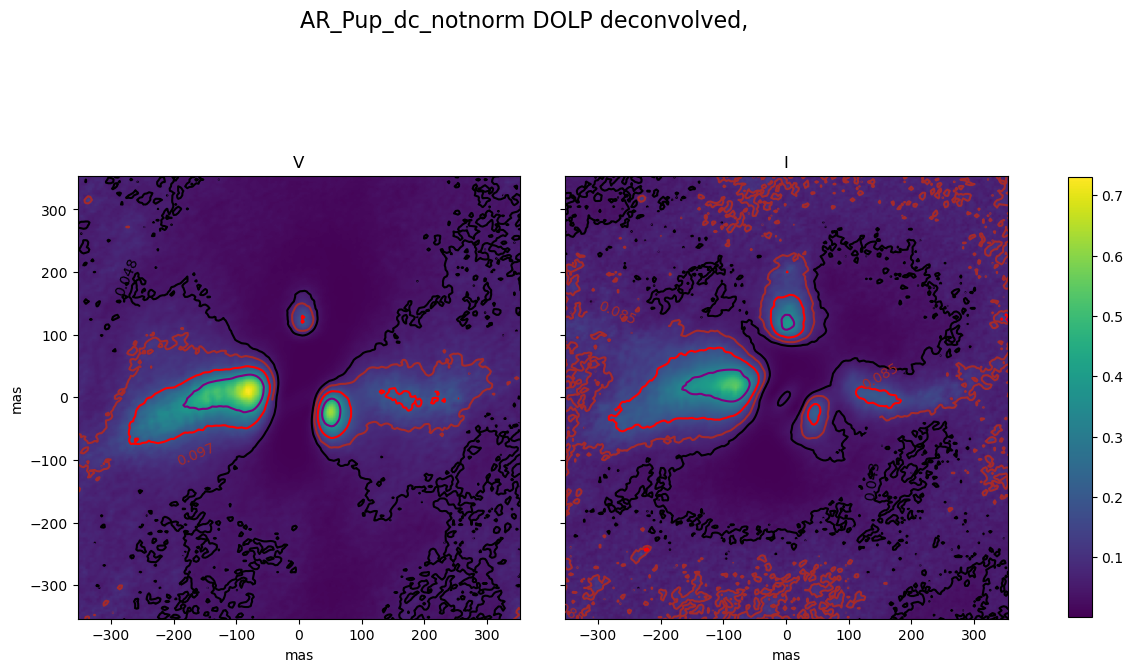

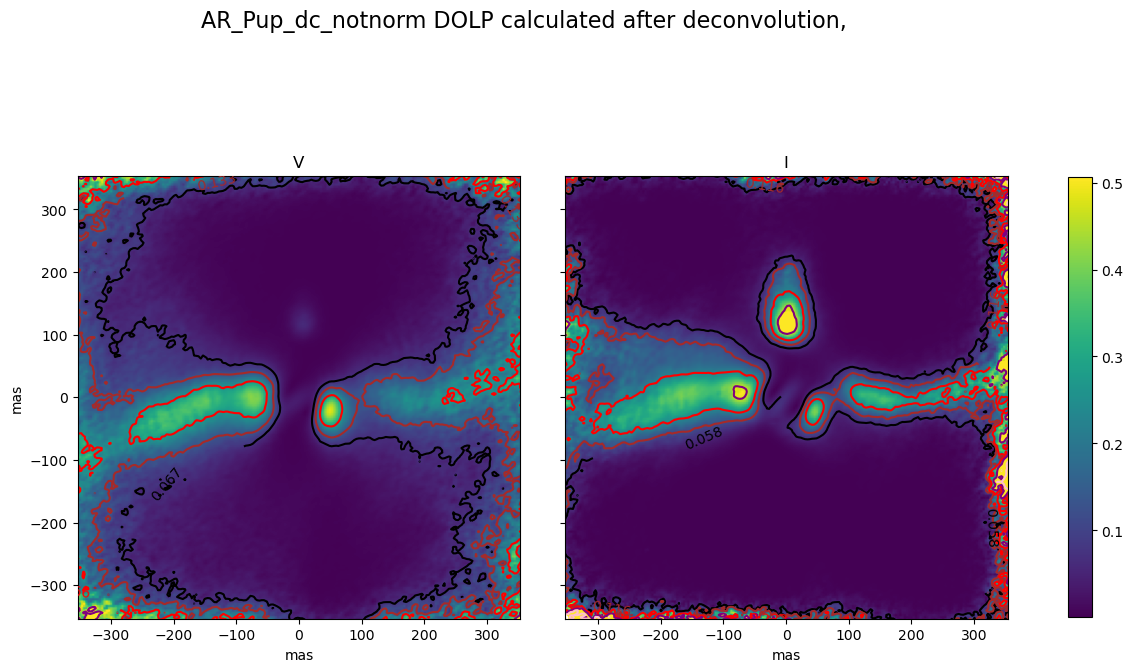

In [11]:
figfolder=dirdat0+'After_deconv/'
createfolder(figfolder)
figfolder=figfolder+star+'/'
createfolder(figfolder)

dirdat = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Deconvolution_corr_tel/'+star+'/'  
for fittype in fittypes:
    print(band[int(fittype)-1])
    output_filename = dirdat+star+'_'+band[int(fittype)-1]+'after_allcorr_stats.txt'
    with open(output_filename, 'w') as file_print:
        line="{:<30} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} ".format('reference',"max_DoLP[%]", "max_Q_phi", "max_PI", "sumQ_phi/I[%]","sumPI/I[%]", 'sumIe6')
        #"{:<30} {:<10} {:<10} {:<10} {:<15}{:<10} {:<10} {:<10} {:<10}  \n".format('reference',"max_DoLP[%]", "max_Q_phi", "max_PI", 'Peak_I(Strehl)','Peak_PI','Peak_Qphi', "sumQ_phi/I[%]","sumPI/I[%]")

        print(line)
        file_print.write(line) 

        dir =dirdat +'/deconvolved_'+'Q_phi'+'/' 
        Q_phi_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
        dir =dirdat +'/deconvolved_'+'PI'+'/'
        PI_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
        dir =dirdat +'/deconvolved_'+'I'+'/' 
        I_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
        dir =dirdat +'/deconvolved_'+'DOLP'+'/'
        DOLP_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])

        I=LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'Unres+PSFcorr/'+star+'/',star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
        #PSF,n= Loadimagespsf(ref_of_sci[star],'/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/'+ref_of_sci[star]+'/filtered/',band[int(fittype)-1])  


        frac =np.max(np.divide(PI_decon,I,where=I!=0)*(R<=150))*100
        mask=(R<=normlim)
        qphi_sum=np.sum(Q_phi_decon[mask])
        I_sum=np.sum(I[R<=1500/ps])
        pi_sum=np.sum(PI_decon[mask])


        line = "{:<30} {:<10.3f} {:<10.3f}  {:<10.3f} {:<10.3f} {:<10.3f}  {:<10.5f}".format('deconvolved',
            frac, np.max(Q_phi_decon), np.max(PI_decon), qphi_sum/I_sum*100, pi_sum/I_sum*100,I_sum/10e6)
        print(line)
        file_print.write(line) 


        if star!='AR_Pup_dc_notnorm':
            f_q= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',ref_of_sci[star]+band[int(fittype)-1]+'band_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
            f_pi= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',ref_of_sci[star]+band[int(fittype)-1]+'band_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
        elif star=='AR_Pup_dc_notnorm':
            f_q= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',band[int(fittype)-1]+'band_qphi_circular_f_psf_50.fits')
            f_pi= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',band[int(fittype)-1]+'band_pi_circular_f_psf_50.fits')


        Q_phi_decon_smear=Q_phi_decon*f_q
        PI_decon_smear=PI_decon*f_pi



        frac =np.max(np.divide(PI_decon_smear,I,where=I!=0)*(R<=150))*100
        mask=(R<=normlim)
        qphi_sum=np.sum(Q_phi_decon_smear[mask])
        pi_sum=np.sum(PI_decon_smear[mask])

        line = "{:<30} {:<10.3f} {:<10.3f}  {:<10.3f} {:<10.3f} {:<10.3f}  ".format('deconvolved+smearing',
            frac, np.max(Q_phi_decon_smear), np.max(PI_decon_smear), qphi_sum/I_sum*100, pi_sum/I_sum*100)
        print(line)
        file_print.write(line) 


    keys=['deconv+smearing','deconv']
    labels={'deconv+smearing':'deconv+smearing','deconv':'only deconv'}
    data={'deconv+smearing': Q_phi_decon_smear ,'deconv':Q_phi_decon}
    cameras=['ZIMPOL','ZIMPOL']
    plot_with_same_color(data, keys, labels ,'Q_phi',star+', PSF smearing test '+ref_of_sci[star]+', '+band[int(fittype)-1]+ ' band',10*ps,True,cameras)
    plt.savefig(figfolder+band[int(fittype)-1]+'band_qphi_decon+PSF_smear.png',bbox_inches='tight', pad_inches=0.1)
    #plt.show()
    plt.close()





    out_fits = fits.HDUList(fits.PrimaryHDU(Q_phi_decon_smear))                  # create output fits structure
    out_fits.writeto(figfolder+band[int(fittype)-1]+'band_qphi_decon+PSF_smear.fits', overwrite = True)                       # write output
    out_fits = fits.HDUList(fits.PrimaryHDU(PI_decon_smear))                  # create output fits structure
    out_fits.writeto(figfolder+band[int(fittype)-1]+'band_pi_decon+PSF_smear.fits', overwrite = True)                       # write output

    DOLP_calculated_after_deconv=np.divide(PI_decon,I_decon,where=I_decon!=0)


    if band[int(fittype)-1]=='I':
        Q_phi_decon_I=Q_phi_decon
        PI_decon_I=PI_decon
        I_decon_I=I_decon
        DOLP_decon_I=DOLP_decon
        DOLP_calculated_after_deconv_I=DOLP_calculated_after_deconv
    if band[int(fittype)-1]=='V':
        Q_phi_decon_V=Q_phi_decon
        PI_decon_V=PI_decon
        I_decon_V=I_decon
        DOLP_decon_V=DOLP_decon
        DOLP_calculated_after_deconv_V=DOLP_calculated_after_deconv


keys=['V','I']
labels={'V':'V','I':'I'}
cameras=['ZIMPOL','ZIMPOL']

data={'V': Q_phi_decon_V ,'I':Q_phi_decon_I}
plot_with_same_color(data, keys, labels ,'Q_phi deconvolved, ',star,8*ps,True,cameras)
plt.savefig(figfolder+star+'_PI_deconv_both_bands.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()            

data={'V': PI_decon_V ,'I':PI_decon_I}
plot_with_same_color(data, keys, labels ,'PI deconvolved, ',star,8*ps,True,cameras)
plt.savefig(figfolder+star+'_PI_deconv_both_bands.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()  


data={'V': I_decon_V ,'I':I_decon_I}
plot_with_same_color(data, keys, labels ,'I deconvolved, ',star,8*ps,True,cameras)
plt.savefig(figfolder+star+'_I_deconv_both_bands.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()  

data={'V': DOLP_decon_V ,'I':DOLP_decon_I}
plot_with_same_color(data, keys, labels ,'DOLP deconvolved, ',star,8*ps,False,cameras)
plt.savefig(figfolder+star+'_DOLP_deconv_both_bands.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()  
DOLP_calculated_after_deconv

data={'V': DOLP_calculated_after_deconv_V ,'I':DOLP_calculated_after_deconv_I}
plot_with_same_color(data, keys, labels ,'DOLP calculated after deconvolution, ',star,8*ps,False,cameras)
plt.savefig(figfolder+star+'_DOLP_calc_after_deconv_both_bands.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()  




V


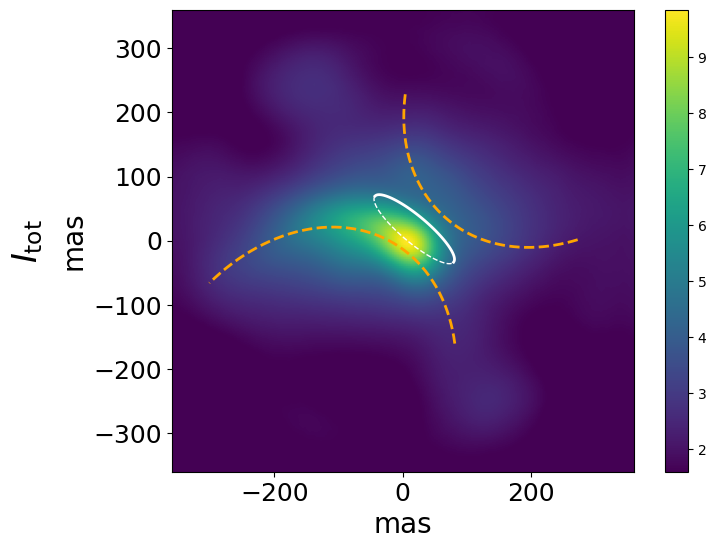

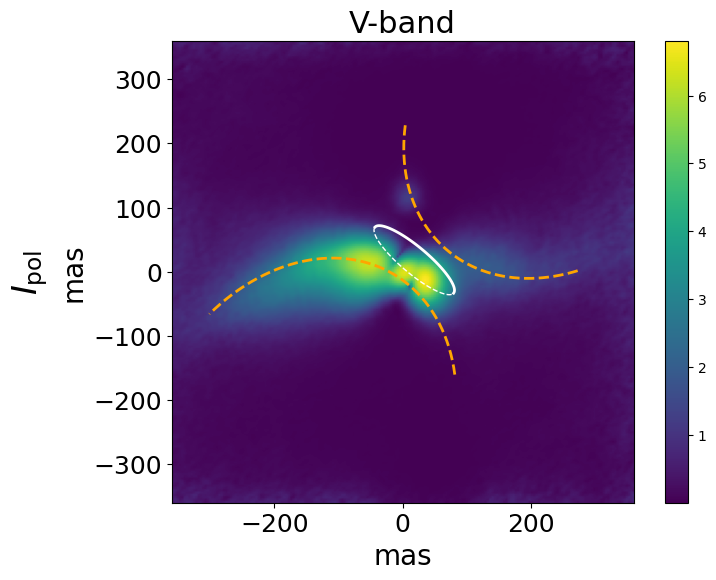

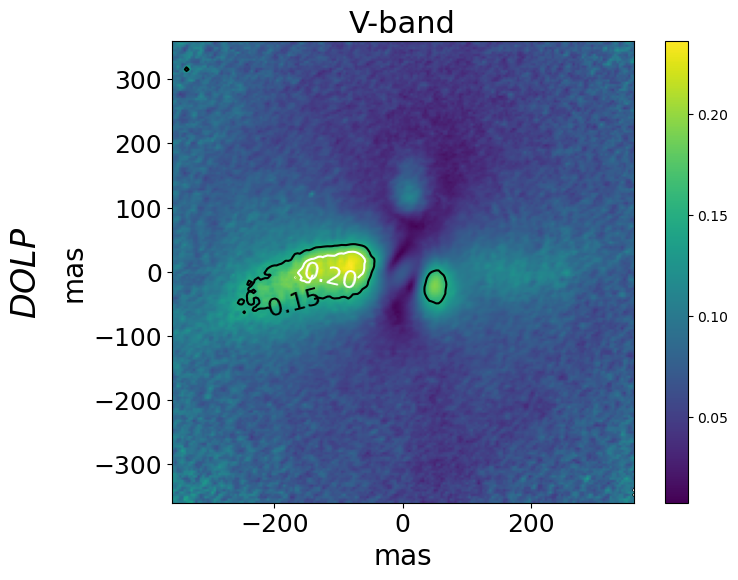

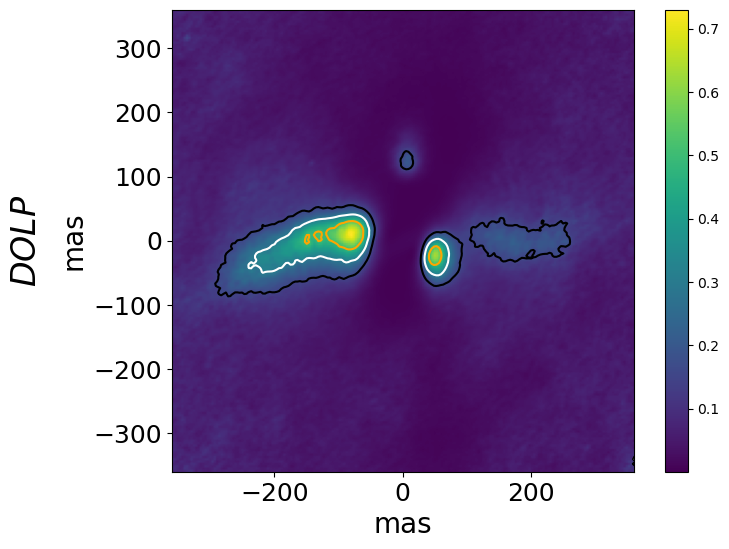

I


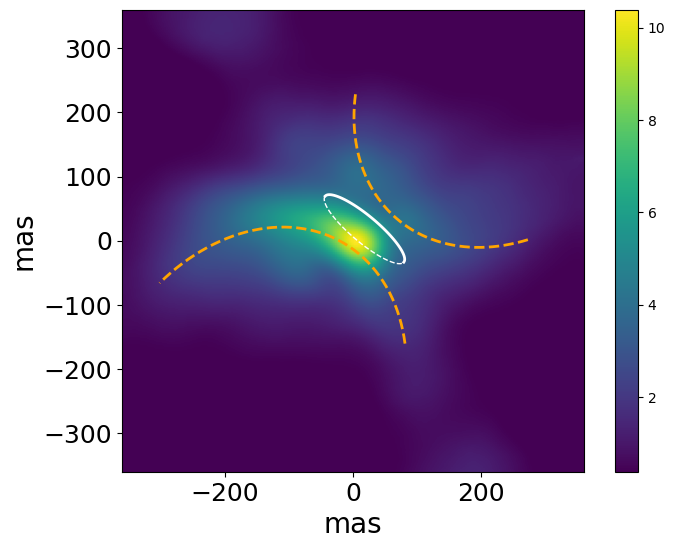

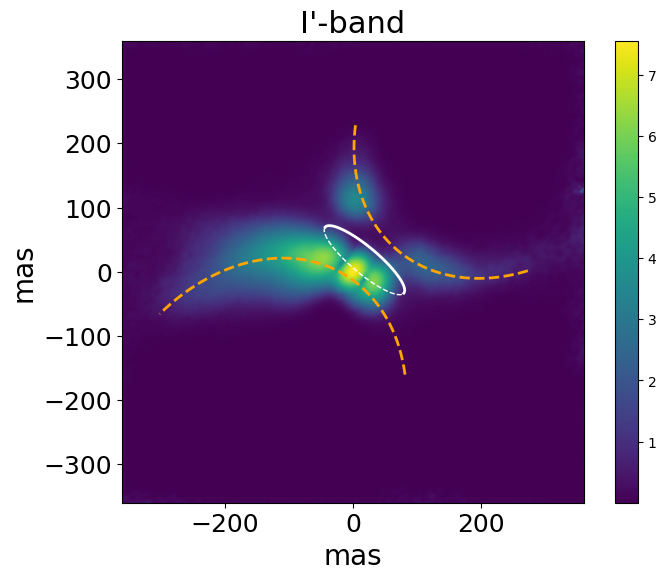

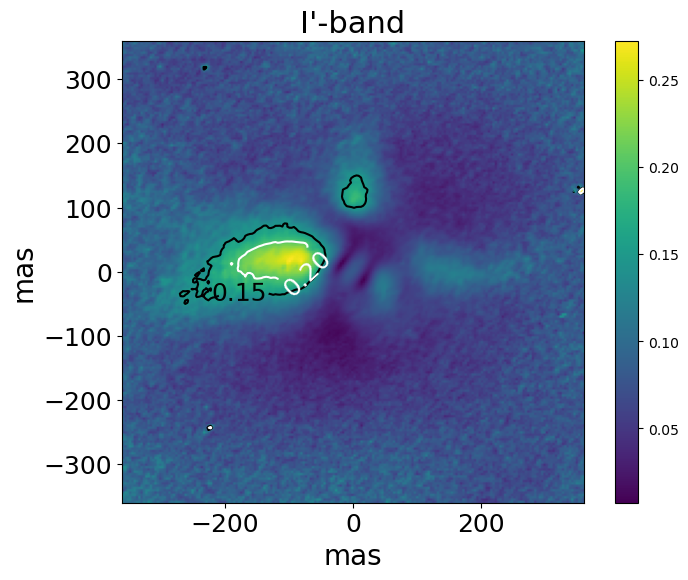

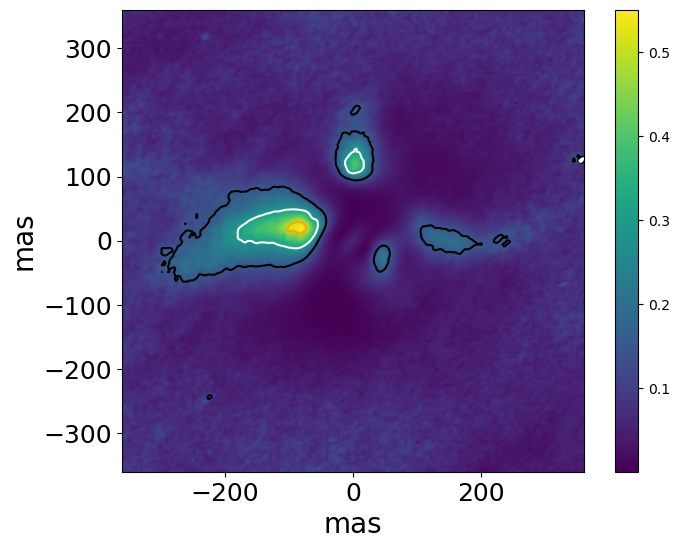

In [20]:
figfolder=dirdat0+'After_deconv/'
createfolder(figfolder)
figfolder=figfolder+star+'/'
createfolder(figfolder)


def plotImage_lin(image, lim):
    n = image.shape[0]
    fig, ax = plt.subplots(figsize=(8,6))
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for zimpol
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas', fontsize=20)
    plt.ylabel('mas', fontsize=20)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)     
    plt.colorbar()
    plt.tight_layout
    return fig, ax


dirdat = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Deconvolution_corr_tel/'+star+'/'  
for fittype in fittypes:
    print(band[int(fittype)-1])

    dir =dirdat +'/deconvolved_'+'Q_phi'+'/' 
    Q_phi_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
    dir =dirdat +'/deconvolved_'+'PI'+'/'
    PI_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
    dir =dirdat +'/deconvolved_'+'I'+'/' 
    I_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
    dir =dirdat +'/deconvolved_'+'DOLP'+'/'
    DOLP_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])

    
    PI=LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'Unres+PSFcorr/'+star+'/',star+'_'+band[int(fittype)-1]+'_'+'PI'+'_meancombined.fits')
    I=LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'Unres+PSFcorr/'+star+'/',star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
    #PSF,n= Loadimagespsf(ref_of_sci[star],'/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/'+ref_of_sci[star]+'/filtered/',band[int(fittype)-1])  



    
    DOLP_calculated_after_deconv=np.divide(PI_decon,I_decon,where=I_decon!=0)
    DOLP=np.divide(PI,I,where=I!=0)


    if band[int(fittype)-1]=='I':
        Q_phi_decon_I=Q_phi_decon
        PI_decon_I=PI_decon
        I_decon_I=I_decon
        DOLP_decon_I=DOLP_decon
        DOLP_calculated_after_deconv_I=DOLP_calculated_after_deconv
        
    if band[int(fittype)-1]=='V':
        Q_phi_decon_V=Q_phi_decon
        PI_decon_V=PI_decon
        I_decon_V=I_decon
        DOLP_decon_V=DOLP_decon
        DOLP_calculated_after_deconv_V=DOLP_calculated_after_deconv

        
        
    ell = EllipseModel()
 
    #substructures
    xcs=ycs=73
    a=300/ps
    b=a*np.cos(np.deg2rad(40))
    theta=np.deg2rad(50)

    points_subtr1=ell.predict_xy(np.linspace(np.deg2rad(130), np.deg2rad(230), 50),params=(xcs,ycs,a,b,theta))

    xcs=43+3
    ycs=68+5
    a=300/ps
    b=a*np.cos(np.deg2rad(40))
    theta=np.deg2rad(60)

    points_subtr2=ell.predict_xy(np.linspace(np.deg2rad(-45), np.deg2rad(70), 50),params=(-xcs,-ycs,a,b,theta))

    xc=yc=5
    a=80/ps
    b=a*np.cos(np.deg2rad(75))
    theta=np.deg2rad(50+90)
    
    fig,ax=plotImage(I_decon, 100)
    #if band[int(fittype)-1]=='I':
    #    plt.title(band[int(fittype)-1]+"'-band", fontsize=22)
    #    
    #else:
    #    plt.title(band[int(fittype)-1]+"-band", fontsize=22)
    if band[int(fittype)-1]=='V':
        ax.text(-0.35, 0.5,r'$I_{\rm tot}$' , transform=ax.transAxes, fontsize=24, va='center', rotation=90)
       
    points=ell.predict_xy(np.linspace(np.pi,  2*np.pi, 50),params=(xc,yc,a,b,theta))
    points_plus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b,theta+np.deg2rad(10)))
    points_minus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b,theta-np.deg2rad(10)))

    plt.plot(points[:,0]*ps,points[:,1]*ps, lw=2, color='white')
    plt.plot(points_dash[:,0]*ps,points_dash[:,1]*ps, lw=1,ls='--', color='white')
    #plt.plot(points_plus[:,0]*ps,points_plus[:,1]*ps, lw=1,ls='--', color='white')
    #plt.plot(points_minus[:,0]*ps,points_minus[:,1]*ps, lw=1,ls='--', color='white')
    plt.plot(points_subtr1[:,0]*ps,points_subtr1[:,1]*ps, lw=2,ls='--', color='orange')
    plt.plot(points_subtr2[:,0]*ps,points_subtr2[:,1]*ps, lw=2,ls='--', color='orange')

    plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_I_deconv.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
    
    fig,ax=plotImage(PI_decon, 100)
    if band[int(fittype)-1]=='I':
        plt.title(band[int(fittype)-1]+"'-band", fontsize=22)
        
    else:
        plt.title(band[int(fittype)-1]+"-band", fontsize=22)
        ax.text(-0.35, 0.5,r'$I_{\rm pol}$' , transform=ax.transAxes, fontsize=24, va='center', rotation=90)
    
    points=ell.predict_xy(np.linspace(np.pi,  2*np.pi, 50),params=(xc,yc,a,b,theta))
    points_dash=ell.predict_xy(np.linspace(0,  np.pi, 50),params=(xc,yc,a,b,theta))
    points_plus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b,theta+np.deg2rad(10)))
    points_minus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b,theta-np.deg2rad(10)))

    plt.plot(points[:,0]*ps,points[:,1]*ps, lw=2, color='white')
    plt.plot(points_dash[:,0]*ps,points_dash[:,1]*ps, lw=1,ls='--', color='white')
    #plt.plot(points_minus[:,0]*ps,points_minus[:,1]*ps, lw=1,ls='--', color='white')
    plt.plot(points_subtr1[:,0]*ps,points_subtr1[:,1]*ps, lw=2,ls='--', color='orange')
    plt.plot(points_subtr2[:,0]*ps,points_subtr2[:,1]*ps, lw=2,ls='--', color='orange')

    plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_PI_deconv.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
    
    
    
    
    n=DOLP.shape[0]
    d = n * ps / 2
    
    fig,ax=plotImage_lin(DOLP, 100)
    levels=[0.15,0.20]
    CS=ax.contour(DOLP, levels=levels,colors=['black','white'], extent=(-d, d, -d, d))
    ax.clabel(CS, inline=True, fontsize=18)

    if band[int(fittype)-1]=='I':
        plt.title(band[int(fittype)-1]+"'-band", fontsize=22)
    else:
        plt.title(band[int(fittype)-1]+"-band", fontsize=22)
        ax.text(-0.35, 0.5,r'$DOLP$' , transform=ax.transAxes, fontsize=24, va='center', rotation=90)
    plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_DOLP.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
    fig,ax=plotImage_lin(DOLP_decon, 100)
    levels=[0.15,0.3,0.5]
    CS=ax.contour(DOLP_decon, levels=levels,colors=['black','white','orange'], extent=(-d, d, -d, d))
    #ax.clabel(CS, inline=True, fontsize=18)

    # if band[int(fittype)-1]=='I':
    #     plt.title(band[int(fittype)-1]+"'-band", fontsize=22)
    # else:
    #     plt.title(band[int(fittype)-1]+"-band", fontsize=22)
    if band[int(fittype)-1]=='V':
        ax.text(-0.35, 0.5,r'$DOLP$' , transform=ax.transAxes, fontsize=24, va='center', rotation=90)
    plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_DOLP_decon.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
    


## Radial brightness profile



1024
AR_Pup_dc_notnorm_V_Q_phi_corr_smearing_tel+unres+PSF_smear.fits
1e-16


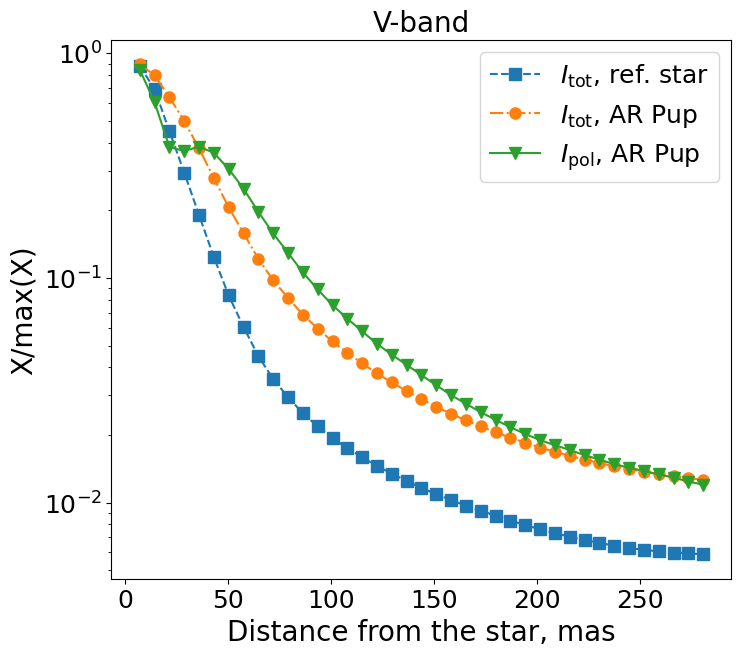

for pixel to pixel I-PSF  % 25.206225337386517
1024
AR_Pup_dc_notnorm_I_Q_phi_corr_smearing_tel+unres+PSF_smear.fits
1e-16


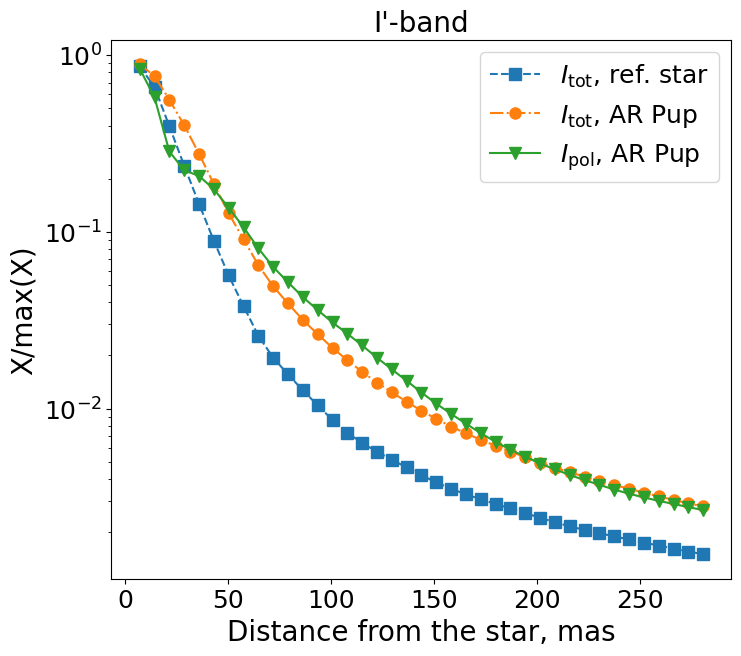

for pixel to pixel I-PSF  % 25.368053231831077


In [5]:

radial_prof=False
if radial_prof:
    def Loadimagespsf(star,dirdat,band):
        dir = dirdat
        qfile = '*_'+band+'_I_meancombined.fits'
        files = os.listdir(dir)
        image=[]
        for file in files:
            if fnmatch.fnmatch(file, qfile):
                with fits.open(dir + file) as hdul:
                    image = hdul[0].data
                    n = image.shape[0]

                    print(n)
        return image, n

    def Loadimages(star,fittype,dirdat,band, extension):
        dir = dirdat
        qfile = '*'+band+'_'+fittype+extension+'.fits'
        files = os.listdir(dir)
        image=[]
        for file in files:
            if fnmatch.fnmatch(file, qfile):

                with fits.open(dir + file) as hdul:
                    image = hdul[0].data
                    n = image.shape[0]

        return image, n



    def plotImage(image, lim):
        n = image.shape[0]

        fig, ax = plt.subplots(figsize=(8,6))
        image = np.arcsinh(image)
        max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        ps = 3.6 #mas per pixel for zimpol
        d = n * ps / 2
        plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
        #plt.plot(0, 0, "+", color="red")
        plt.xlim(-lim * ps, lim * ps)
        plt.ylim(-lim * ps, lim * ps)
        plt.xlabel('mas',fontsize=18)
        plt.ylabel("mas",fontsize=18)
        plt.colorbar()



    import functions as f


    dirdat0 = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/After_deconv/'

    dirdat='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'Unres+PSFcorr/'+star+'/'
    figfolder='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'scattered/'
    createfolder(figfolder)
    figfolder=figfolder+star+'/'
    createfolder(figfolder)


    #dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/corr_with_ref/tel+unresol+PSF_smearing/Andrych2023/'  #For IRAS08
    xc=511.5
    yc=511.5

    for fittype in fittypes:

        I=LoadImage(dirdat,star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
        PSF,n= Loadimagespsf(ref_of_sci[star],'/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/filtered/'+ref_of_sci[star]+'/',band[int(fittype)-1])  
        PI_unres, n=Loadimages(star,'PI',dirdat,band[int(fittype)-1],'_corr_'+'tel+unres')
        PI=LoadImage(dirdat,star+'_'+band[int(fittype)-1]+'_'+'PI'+'_meancombined.fits')
        #U=LoadImage(dirdat,star+'_'+band[int(fittype)-1]+'_'+'U_phi'+'_meancombined.fits')
        Qphi, n=Loadimages_notdeconv(star,'Q_phi',dirdat, band[int(fittype)-1],'_corr_smearing_tel+unres+PSF_smear') 

        mask=(R<=500/ps)
        PSF=PSF#$/np.sum(PSF[mask])*10e6
        #print(np.max(I[mask]))
        #print(np.max(PI[mask]))


        norm=np.max(PI[mask])
        #PSF=PSF*norm

        I=I/np.max(I[mask])
        PSF=PSF/np.max(PSF[mask])
        #I=I/norm
        PI=PI/norm
        Qphi=Qphi/np.max(Qphi)
        #PI_unres=PI_unres/norm

        #radial_brightness

        xr = np.linspace(0, n, num=n)
        yr = np.linspace(0, n, num=n)
        xr = xr-xc
        yr = yr-yc
        Xr, Yr = np.meshgrid(xr, yr)            
        R=np.sqrt(Xr**2 + (Yr)**2)
        r, pos_angle = f.cart2polar_for_mask_defining(Xr, Yr)
        pos_angle=np.rad2deg(pos_angle)+180


        I_mean_ar=[]
        PSF_mean_ar=[]
        PI_mean_ar=[]
        PI_unres_mean_ar=[]
        Qphi_mean_ar=[]
        #var_ar=[]
        for i_r in range (2,80,2):

            width=math.sqrt(i_r)/2
            mask = (R < i_r+width) & (R >=(i_r-width))# & (pos_angle>startang)& (pos_angle<endang)
            image_I=I[mask]
            image_PI=PI[mask]
            image_PSF=PSF[mask]
            image_PI_unres=PI_unres[mask]
            image_Qphi=Qphi[mask]
           # image_u=U[mask]
            #error=np.nanstd(image_u)/math.sqrt(len(image_u))/np.max(PI[mask])


            i_r_stop=i_r
            I_mean=np.mean(image_I)
            PSF_mean=np.mean(image_PSF)
            I_mean_ar.append(I_mean)
            PSF_mean_ar.append(PSF_mean)
            PI_mean=np.mean(image_PI)
            PI_mean_ar.append(PI_mean)
            PI_unres_mean=np.mean(image_PI_unres)
            PI_unres_mean_ar.append(PI_unres_mean)
            Qphi_mean=np.mean(image_Qphi)
            Qphi_mean_ar.append(Qphi_mean)
           # var_ar.append(error)




        i_rad=[float(x)*ps for x in range (2,i_r_stop+1,2)]    
        #plt.plot(i_rad,q_mean)
        #print(len(i_rad),len(q_mean_ar),len(var_ar))

        fig, (ax1) = plt.subplots(1, 1,figsize=(8,7))
        plt.errorbar(i_rad,PSF_mean_ar, label=r'$I_{\rm tot}$, ref. star',fmt='--s', markersize=8)
        plt.errorbar(i_rad,I_mean_ar, label=r'$I_{\rm tot}$, '+'AR Pup', fmt='-.o', markersize=8)
        plt.errorbar(i_rad,PI_mean_ar, label=r'$I_{\rm pol}$, '+'AR Pup', fmt='-v', markersize=9)
        plt.ylabel(r'X/max(X)', fontsize=20)
        plt.xlabel('Distance from the star, mas', fontsize=20)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        if band[int(fittype)-1]=='I':
            plt.title(band[int(fittype)-1]+"'-band",fontsize=20)
        else:
            plt.title(band[int(fittype)-1]+"-band",fontsize=20)
        plt.legend(fontsize=18)
        plt.yscale('log')

        plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_scattered.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

        scattered=I-PSF
        scattered_pos=scattered*(scattered>=0)+1e-15*(scattered<0)



        Iscat_full=np.sum(scattered_pos*(R<=i_r))/np.sum(I*(R<=1500/ps))
        print('for pixel to pixel I-PSF  %',Iscat_full*100)


In [6]:
#fitting ellipse to rings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
from astropy.io import fits
import os, fnmatch
import matplotlib.gridspec as gridspec
from scipy import optimize
from skimage.measure import EllipseModel
from scipy import interpolate
from textwrap import wrap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from skimage.measure import profile_line
import matplotlib.patches as patches
from scipy.optimize import curve_fit

starnames = {'HD75885':'HD75885','AR_Pup_dc_notnorm':'AR Pup','HR4049_combined':'HR4049','HR4049_20190108':'HR4049/2019-01-08','HR4049_20190107':'HR4049/2019-01-07','IRAS08544-4431':'IRAS08544-4431','UMon':'U Mon','AR_Pup_flat4':'AR_Pup_flat4','V709_Car':'V709 Car','UMon_calibV390':'UMon_calibV390','HR4226':'HR4226','UMon_Katya':'U Mon'}
fittype='PI'
annulus='I'
    
savefig='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'AR_Pup_ellipse/'
try:
 # Create target Directory
   os.mkdir(savefig)
except FileExistsError:
    print()
lim=100

PI_I, n=Loadimages_notdeconv(star,'PI',dirdat,'I','_meancombined')
PI_V, n=Loadimages_notdeconv(star,'PI',dirdat,'V','_meancombined')
Q_phi_I, n=Loadimages_notdeconv(star,'Q_phi',dirdat,'I','_meancombined')
Q_phi_V, n=Loadimages_notdeconv(star,'Q_phi',dirdat,'V','_meancombined')

dirdat = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Deconvolution_corr_tel/'+star+'/'  
dir =dirdat +'/deconvolved_'+'I'+'/' 
I_I, R, x, y, d_in,X,Y= LoadImage_dec(dir,'I')
I_V, R, x, y, d_in,X,Y= LoadImage_dec(dir,'V')
dir =dirdat +'/deconvolved_'+'PI'+'/' 
PI_dec_I, R, x, y, d_in,X,Y= LoadImage_dec(dir,'I')
PI_dec_V, R, x, y, d_in,X,Y= LoadImage_dec(dir,'V')
        

xr = np.linspace(0, n, num=n)
yr = np.linspace(0, n, num=n)
xr = xr-xc
yr = yr-yc
Xr, Yr = np.meshgrid(xr, yr)            
R=np.sqrt(Xr**2 + (Yr)**2)



AR_Pup_dc_notnorm_I_PI_meancombined.fits
0.0
AR_Pup_dc_notnorm_V_PI_meancombined.fits
0.0
AR_Pup_dc_notnorm_I_Q_phi_meancombined.fits
1.0000000000000003e-16
AR_Pup_dc_notnorm_V_Q_phi_meancombined.fits
1.0000000000000003e-16


# Just test for substructures

theta 140.00
angle 140.00
511.5 511.5 22.22222222222222 5.751534335611572 2.443460952792061 75.0 0.9659258262890683


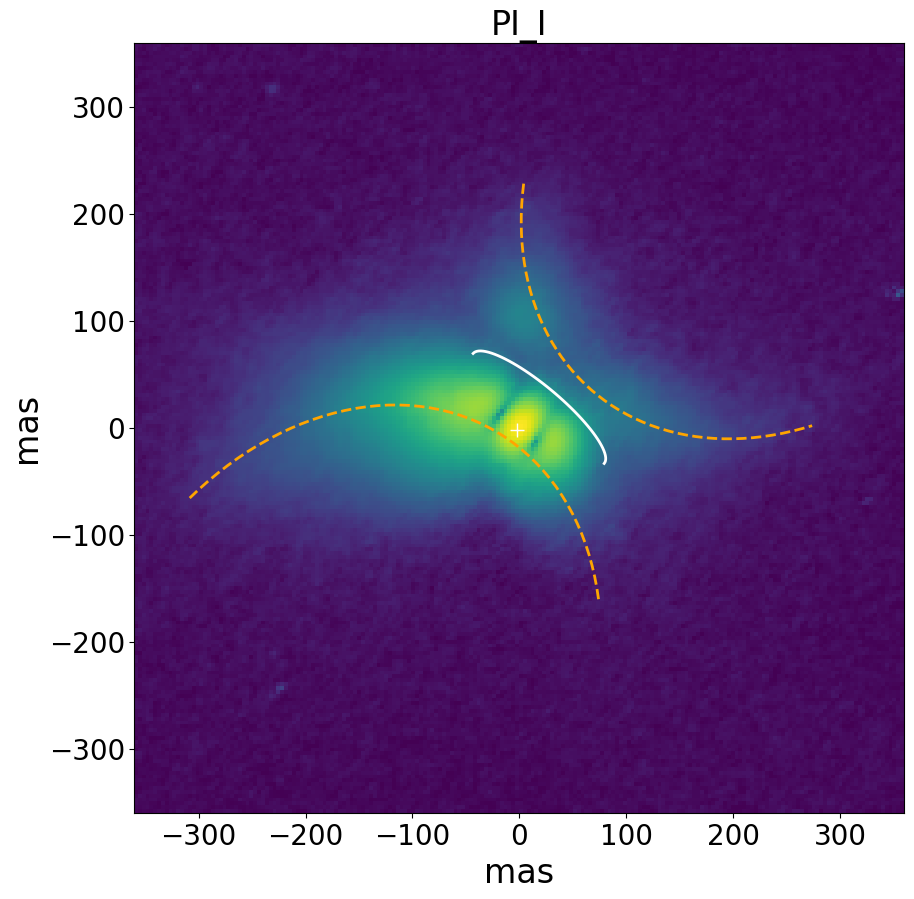

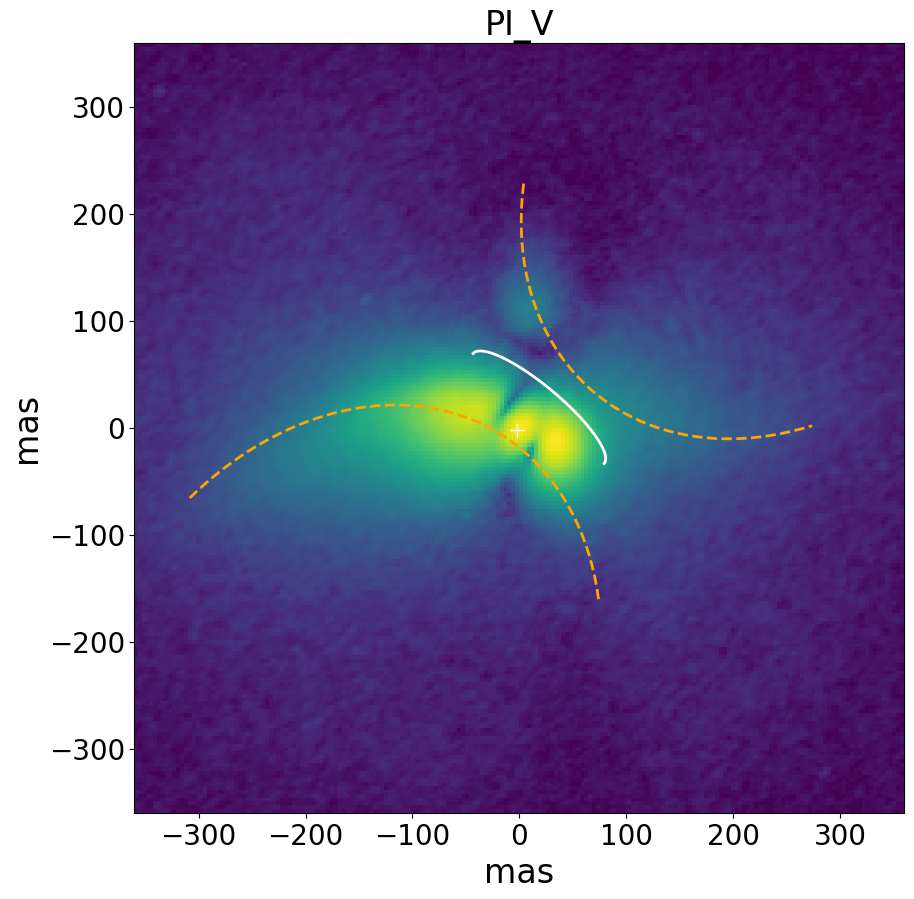

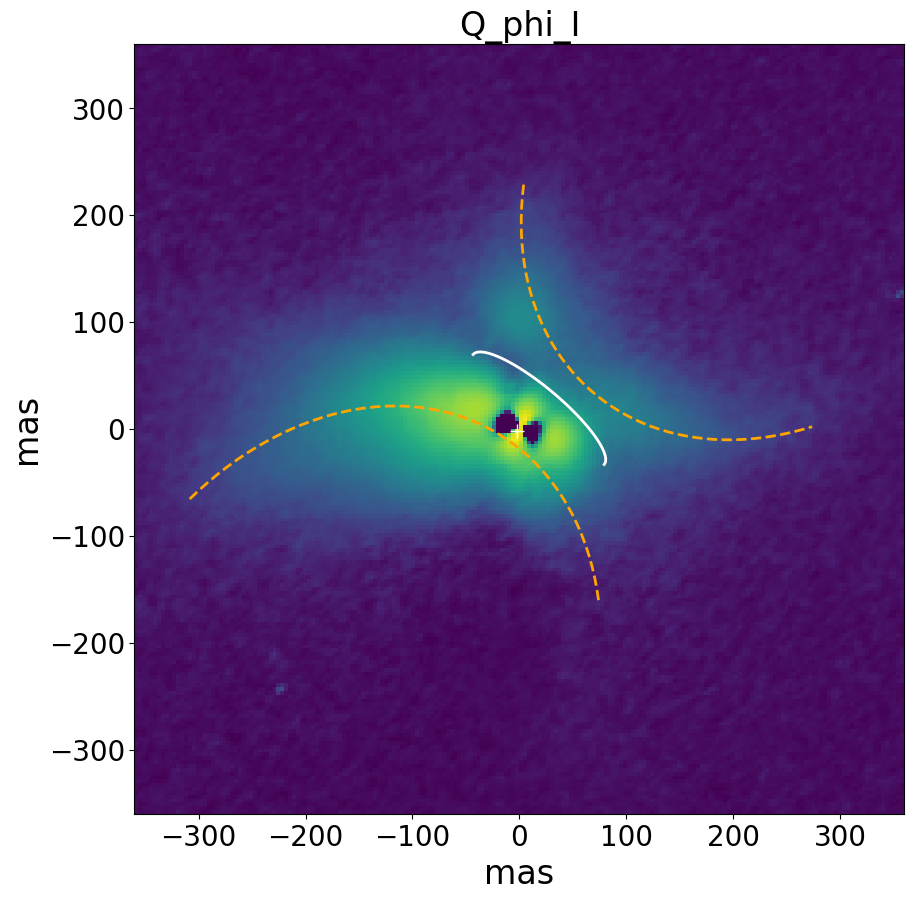

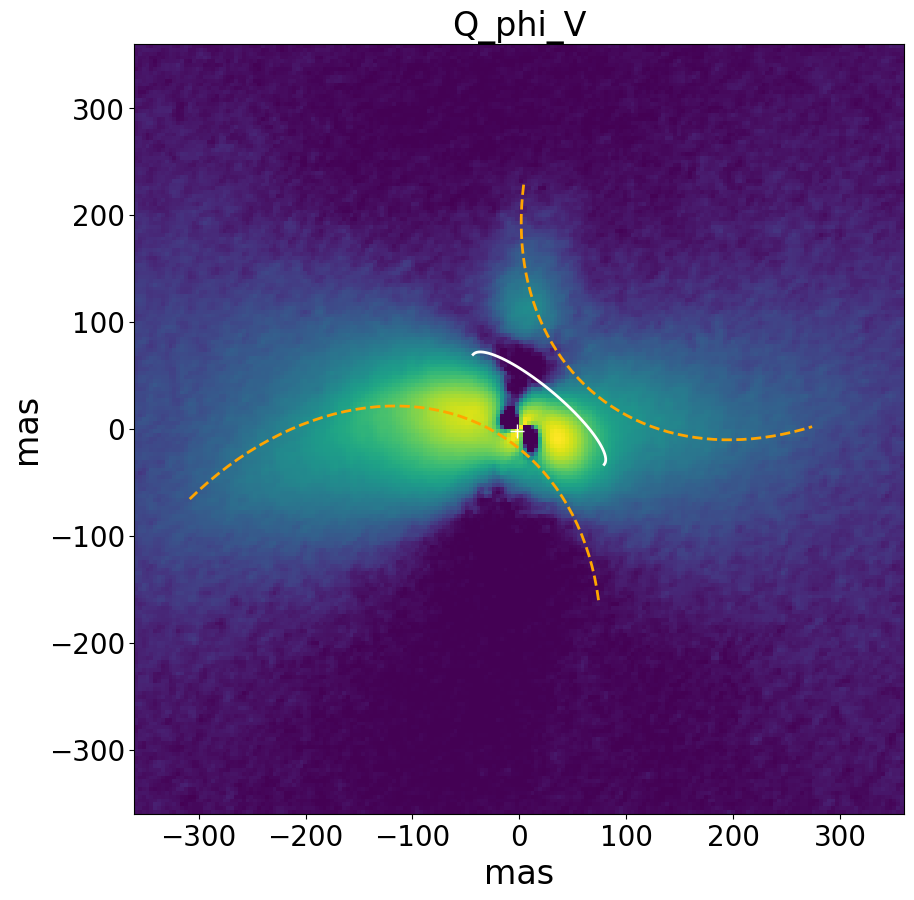

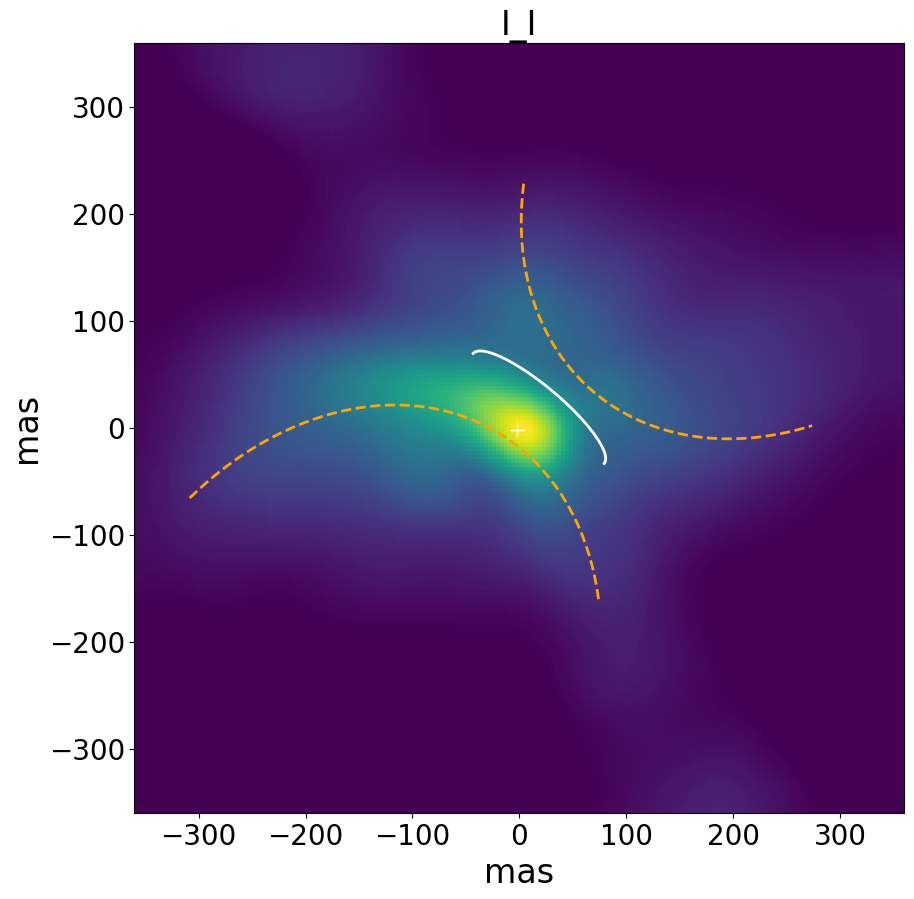

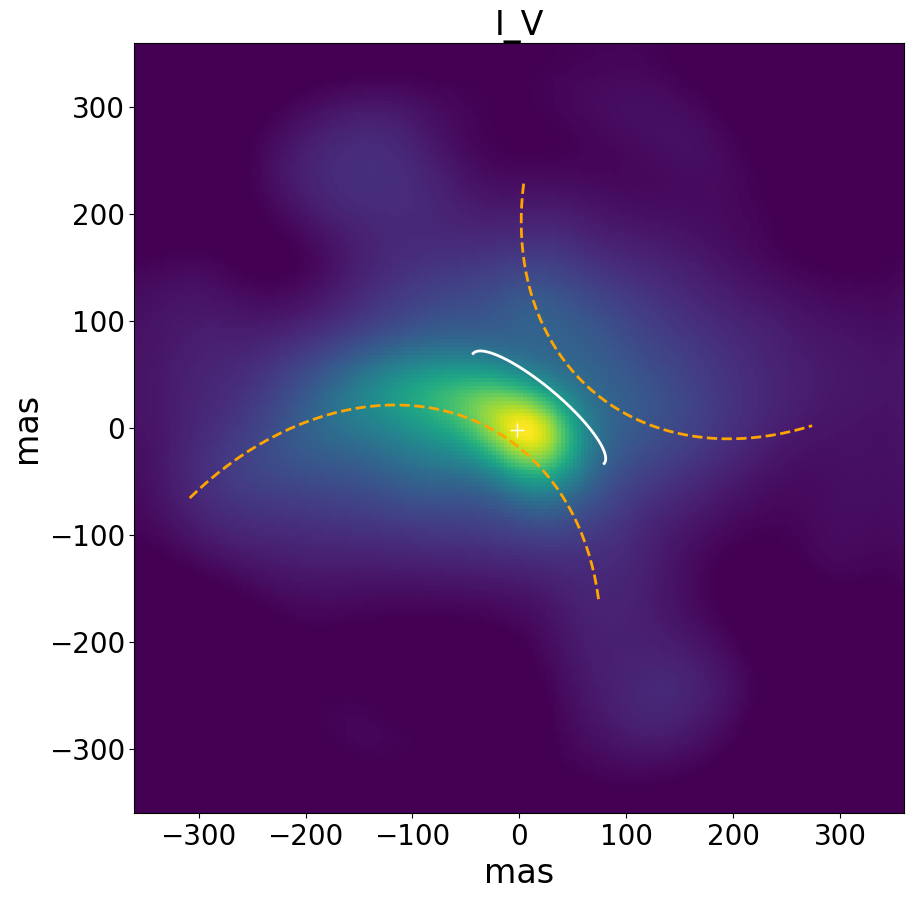

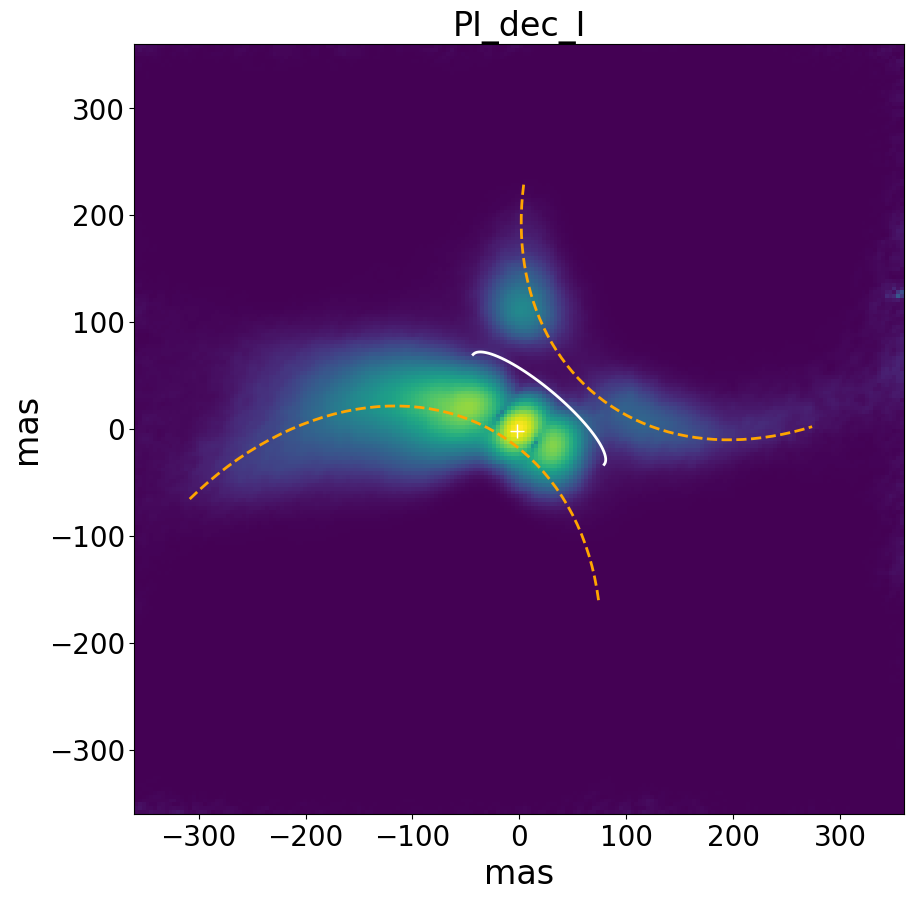

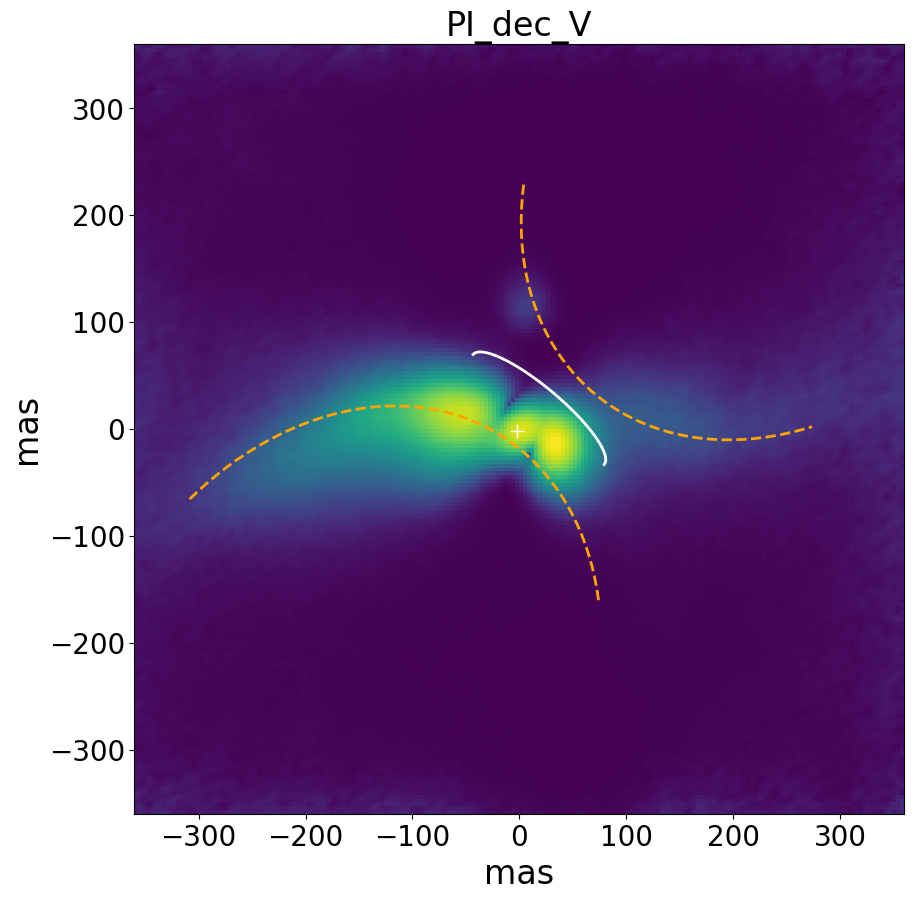

In [7]:
test=False
if test:
    lim=100
    img2=PI*1.0
    Rlimit2=lim

    n=img2.shape[0]
    shift=n/2-0.5

    d=(n-1)*ps/2

    ell = EllipseModel()

    #b_plus=a*np.cos(np.deg2rad(75+10))
    #b_minus=a*np.cos(np.deg2rad(75-10))
    #points_plus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b_plus,theta))
    #points_minus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b_minus,theta))


    ac,bc=a,b
    reverse=False
    if a<b: 
        ac,bc=b,a
        print('reverse')
        reverse=True
    cosi=bc/ac
    ecc=np.sqrt(1-bc*bc/ac/ac)
    print('theta %.2f' % np.rad2deg(theta))
    angle=np.rad2deg(theta)
    #if angle<0: angle=angle+360
    if (a<b):
        if np.rad2deg(theta)<90:
            angle=angle+90
        else:
            angle=angle-90


    print('angle %.2f' % angle)



    xc_in=xc*1.0
    yc_in=yc*1.0
    print(xc, yc, a, b, theta,str(np.rad2deg(np.arccos(cosi))),ecc)

    logfile=open(savefig+star+'_'+annulus+'_ellipse_gauss_fit.txt','w+')
    logfile.writelines(star+'\n')
    logfile.writelines('Annulus for stellar polarisation '+annulus+'\n')
    logfile.writelines("center = (%f , %f) \n" % (xc*ps, yc*ps))
    logfile.writelines("angle of rotation = %f \n" % theta)
    logfile.writelines("half axes im mas= %f, %f \n" % (a*ps,b*ps))

    logfile.writelines('Inclination for the deprojection '+str(np.rad2deg(np.arccos(cosi)))+'\n')
    logfile.writelines('PA '+str(angle)+'\n')
    logfile.writelines('Eccentricity '+str(ecc)+'\n')



     #height of arc
    starposition=[(511.5-n/2),(511.5-n/2)] #center in python array index
    ringshift=math.dist(starposition,[xc,yc])
    sini=np.sqrt(1-cosi*cosi)

    logfile.writelines('\n')
    logfile.close()


    #substructures
    xcs=ycs=73
    a=300/ps
    b=a*np.cos(np.deg2rad(40))
    theta=np.deg2rad(50)

    points_subtr1=ell.predict_xy(np.linspace(np.deg2rad(130), np.deg2rad(230), 50),params=(xcs,ycs,a,b,theta))

    xcs=43+5
    ycs=68+5
    a=300/ps
    b=a*np.cos(np.deg2rad(40))
    theta=np.deg2rad(60)

    points_subtr2=ell.predict_xy(np.linspace(np.deg2rad(-45), np.deg2rad(70), 50),params=(-xcs,-ycs,a,b,theta))





    d=(n)*ps/2
    names=['PI_I','PI_V','Q_phi_I','Q_phi_V','I_I','I_V','PI_dec_I','PI_dec_V']
    files=[PI_I,PI_V,Q_phi_I,Q_phi_V,I_I,I_V,PI_dec_I,PI_dec_V]   
    xc=yc=5
    a=80/ps
    b=a*np.cos(np.deg2rad(75))

    for name, img2 in zip(names,files):


        if name=='PI_V' or name=='Q_phi_V' or name=='I_V' or name=='PI_dec_V':
            theta=np.deg2rad(50+90)
        else:
            theta=np.deg2rad(50+90)



        points=ell.predict_xy(np.linspace(np.pi, 2 * np.pi, 50),params=(xc,yc,a,b,theta))
        points_plus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b,theta+np.deg2rad(10)))
        points_minus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b,theta-np.deg2rad(10)))


        fig, ax = plt.subplots(1, 1,figsize=(10,10))
        image=np.arcsinh(img2)
        max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))

        #northeast2(lim,ps,coef=3)
        plt.xlim(-lim * ps, lim * ps)
        plt.ylim(-lim * ps, lim * ps)

        plt.plot(points[:,0]*ps,points[:,1]*ps, lw=2, color='white')
        #plt.plot(points_plus[:,0]*ps,points_plus[:,1]*ps, lw=1,ls='--', color='white')
        #plt.plot(points_minus[:,0]*ps,points_minus[:,1]*ps, lw=1,ls='--', color='white')
        plt.plot(points_subtr1[:,0]*ps,points_subtr1[:,1]*ps, lw=2,ls='--', color='orange')
        plt.plot(points_subtr2[:,0]*ps,points_subtr2[:,1]*ps, lw=2,ls='--', color='orange')


        #plt.plot(xc*ps, yc*ps, '+',ms=10, color='red')

        ax.plot((511.5-n/2)*ps,(511.5-n/2)*ps, "+",ms=10, color="white")
        plt.xlabel('mas', fontsize=24)
        plt.ylabel("mas", fontsize=24)
        ax.xaxis.set_tick_params(labelsize=20)
        ax.yaxis.set_tick_params(labelsize=20)
        plt.title(name, fontsize=24)
        plt.savefig(savefig+ star+'_'+name+ "_ellipse.jpeg",bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()  
